In [2]:
pip install mplsoccer

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.8/85.8 kB 2.4 MB/s eta 0:00:00


Enter the name of the player: Raphinha


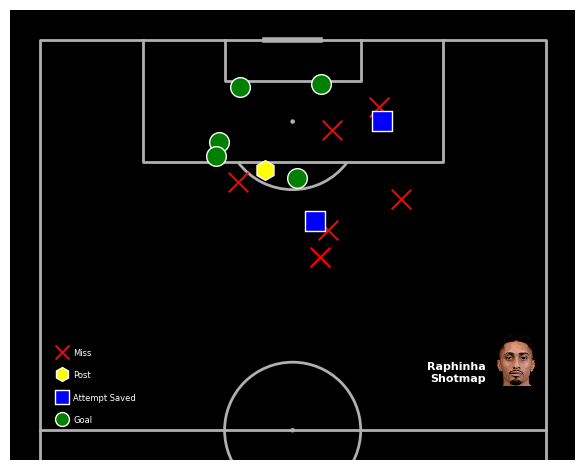

In [5]:
import requests
import json
import pandas as pd
from bs4 import BeautifulSoup
from mplsoccer import VerticalPitch
from PIL import Image
from io import BytesIO
from matplotlib.offsetbox import OffsetImage, AnnotationBbox


def fetch_match_data(url):
    """
    Fetches match data from the given URL and returns the JSON content.

    Args:
        url (str): The URL of the Fotmob match page.

    Returns:
        dict: Parsed JSON data from the match.
    """
    try:
        r = requests.get(url)
        r.raise_for_status()  # Raise HTTPError for bad responses
        soup = BeautifulSoup(r.text, 'html.parser')
        json_data = json.loads(soup.find('script', attrs={'id': '__NEXT_DATA__'}).contents[0])
        return json_data
    except requests.exceptions.RequestException as e:
        print(f"Error fetching data from {url}: {e}")
        return None
    except (json.JSONDecodeError, AttributeError) as e:
        print(f"Error parsing JSON from {url}: {e}")
        return None


def parse_shotmap(json_data):
    """
    Extracts shotmap data from the JSON content.

    Args:
        json_data (dict): JSON content of the match.

    Returns:
        pd.DataFrame: A DataFrame containing shotmap data.
    """
    try:
        shots = json_data['props']['pageProps']['content']['shotmap']['shots']
        return pd.DataFrame(shots)
    except KeyError:
        print("Error: Shotmap data not found in JSON.")
        return pd.DataFrame()


def plot_shotmap(shotmap_df, selected_player):
    """
    Plots a shotmap for the selected player using mplsoccer.

    Args:
        shotmap_df (pd.DataFrame): DataFrame containing shotmap data.
        selected_player (str): Name of the player to visualize.
    """
    selected_player_shots = shotmap_df[shotmap_df['playerName'] == selected_player]

    if selected_player_shots.empty:
        print(f"No shots found for player {selected_player}.")
        return

    pitch = VerticalPitch(pitch_type='uefa', half=True)
    fig, ax = pitch.draw()
    ax.set_facecolor('black')

    for i, shot in selected_player_shots.iterrows():
        color, marker = {
            "Goal": ("green", "o"),
            "AttemptSaved": ("blue", "s"),
            "Post": ("yellow", "h"),
            "Miss": ("red", "x")
        }.get(shot['eventType'], ("white", "?"))

        pitch.scatter(shot['x'], shot['y'], marker=marker, s=200, edgecolor='white', facecolor=color, ax=ax)

    player_id = selected_player_shots['playerId'].iloc[0]
    image_url = f"https://images.fotmob.com/image_resources/playerimages/{player_id}.png"
    try:
        image_response = requests.get(image_url)
        image_response.raise_for_status()
        img = Image.open(BytesIO(image_response.content)).convert('RGBA')
        imagebox = OffsetImage(img, zoom=0.2)
        ab = AnnotationBbox(imagebox, (4, 62), frameon=False)
        ax.add_artist(ab)
    except requests.exceptions.RequestException:
        print("Error fetching player image.")

    pitch.annotate(f"{selected_player}\nShotmap", (59, 8), ax=ax, fontsize=8, color='white', ha='right', weight='bold')

    legend_items = [("Goal", "green", "o"), ("Attempt Saved", "blue", "s"),
                    ("Post", "yellow", "h"), ("Miss", "red", "x")]
    for idx, (label, color, marker) in enumerate(legend_items):
        pitch.scatter(54 + (idx * 3), 65, marker=marker, s=100, edgecolor='white', facecolor=color, ax=ax)
        pitch.annotate(label, (53.8 + (idx * 3), 63.5), ax=ax, fontsize=6, color='white', ha='left', va='center')

    fig.show()


def main():
    """
    Main function to fetch, process, and visualize shotmap data.
    """
    urls = [
        'https://www.fotmob.com/fr/matches/barcelona-vs-monaco/2thjyt#4621541:tab=stats',
        'https://www.fotmob.com/fr/matches/barcelona-vs-young-boys/2xildd#4621538:tab=stats',
        'https://www.fotmob.com/fr/matches/barcelona-vs-bayern-munchen/2tf6hw#4621509:tab=stats',
        'https://www.fotmob.com/fr/matches/barcelona-vs-red-star-belgrade/2hbkp8#4621539:tab=stats',
        'https://www.fotmob.com/matches/brest-vs-barcelona/2fm8n4#4621540:tab=stats',
        'https://www.fotmob.com/fr/matches/barcelona-vs-dortmund/2t1qox#4621528:tab=stats'
    ]

    all_shotmaps = []
    for url in urls:
        data = fetch_match_data(url)
        if data:
            shotmap_df = parse_shotmap(data)
            all_shotmaps.append(shotmap_df)

    combined_shotmap_df = pd.concat(all_shotmaps, ignore_index=True)

    selected_player = input("Enter the name of the player: ")
    plot_shotmap(combined_shotmap_df, selected_player)


if __name__ == "__main__":
    main()
